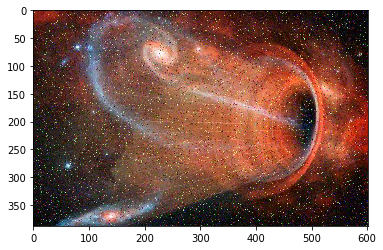

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy.interpolate import BSpline
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter
%matplotlib inline

im = np.array(Image.open('space.jpg'))
imgplot = plt.imshow(im, vmin=0, vmax=255)

# part 1

In [2]:

def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knddddddots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.
    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

In [3]:
def b_smooth(im):    
    ny,nx= im.shape
    k=nx
    XX, YY = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
    sigma = 0.5
    Y = im
    # 2D Spline
    degree = 4-1
    Bs = []
    Hs = []
    for domain in [XX[0, :], YY[:, 0]]:
        lo, hi = min(domain), max(domain)
        B = BSplineBasis(domain, knots=np.linspace(
            lo, hi, 10), degree=degree)[:, :-2]
        Bs.append(B)
        H = B@np.linalg.inv(B.T@B)@B.T
        Hs.append(H)
    Yhat = Hs[1]@Y@Hs[0]
    return Yhat

In [15]:
res = np.zeros(im.shape)
for i in range(3):
    res[:,:,i] = b_smooth(im[:,:,i])

bspline = np.clip(res.astype(int),0,255)

Text(0.5, 1.0, 'After B-spline smoothing')

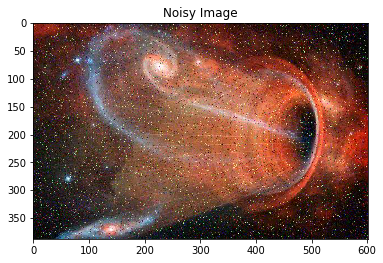

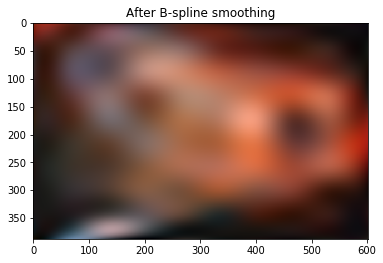

In [16]:
plt.figure()
plt.imshow(im)
plt.title('Noisy Image')
plt.figure()
plt.imshow(bspline)
plt.title('After B-spline smoothing')

# part 2

In [6]:
mask = np.ones((3,3))*1/9
c = np.zeros(im.shape)
for i in range(3):
    c[:,:,i] = ndi.convolve(im[:,:,i], mask)

f = np.clip(c.astype(int),0,255)


In [7]:
ny,nx,_ = im.shape


final = np.zeros(im.shape)
for i in range(3):
    for j in range(im.shape[0]):
        for k in range(im.shape[1]):
            if np.abs(im[j,k,i]-f[j,k,i]) > .003:
                final[j,k,i] = im[j,k,i]
            else:
                final[j,k,i] = f[j,k,i]
final = np.clip(final.astype(int),0,255)

Text(0.5, 1.0, 'After Threshold Averaging')

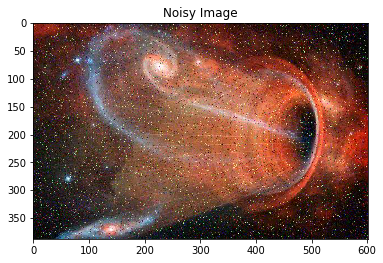

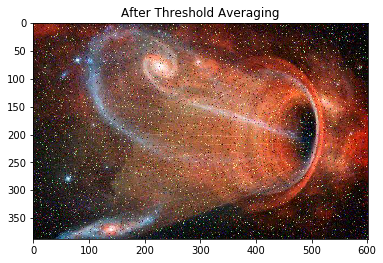

In [8]:
plt.figure()
plt.imshow(im)
plt.title('Noisy Image')
plt.figure()
plt.imshow(final)
plt.title('After Threshold Averaging')

# part 3

In [9]:
# reference: https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/

def gauss_pyramid(image, levels=6):
    output = []
    output.append(image)
    for i in range(0,levels):
        gl = output[-1][::2,::2][:-1,:-1]
        gl = gaussian_filter(gl, sigma=3)
        gl = np.array(Image.fromarray(np.uint8(gl)).resize(image.shape))
        output.append(gl)
    return output

def lapl_pyramid(gauss_pyr):
    output = []
    for i in range(len(gauss_pyr)-1):
        l = gauss_pyr[i] - gauss_pyr[i+1]
        output.append(l)
    output.append(gauss_pyr[-1])
    return output

def blend(fgbl, bgbl, mbl):
    blended = []
    assert len(mbl) == len(bgbl) == len(fgbl)
    for i in range(len(mbl)):
        b = mbl[i]*fgbl[i] + (1 - mbl[i])*bgbl[i]
        blended.append(b)
    return blended

def collapse(lapl_pyr):
    for i in range(len(lapl_pyr)-1,0,-1):
        lap = lapl_pyr[i]
        lapb = lapl_pyr[i-1]
        tmp = lap + lapb
        lapl_pyr.pop()
        lapl_pyr.pop()
        lapl_pyr.append(tmp)  
    return tmp

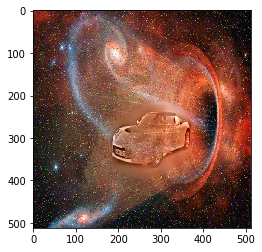

In [10]:
# original
fg = np.array(Image.open('Image_source.jpg').resize((512,512)))
bg = np.array(Image.fromarray(np.uint8(final)).resize((512,512)))
mask = np.array(Image.open('Mask_source.jpg').resize((512,512)))

r1, g1, b1 = cv2.split(fg)
r2, g2, b2 = cv2.split(bg)
bm, gm, rm = (mask,mask,mask)

r1 = r1.astype(float)
g1 = g1.astype(float)
b1 = b1.astype(float)

r2 = r2.astype(float)
g2 = g2.astype(float)
b2 = b2.astype(float)

rm = rm.astype(float)/255
gm = gm.astype(float)/255
bm = bm.astype(float)/255

# gaus
fgbg = gauss_pyramid(b1)
fggg = gauss_pyramid(g1)
fgrg = gauss_pyramid(r1)


bgbg = gauss_pyramid(b2)
bggg = gauss_pyramid(g2)
bgrg = gauss_pyramid(r2)

mbg = gauss_pyramid(bm)
mgg = gauss_pyramid(gm)
mrg = gauss_pyramid(rm)

# lap
fgbl = lapl_pyramid(fgbg)
fggl = lapl_pyramid(fggg)
fgrl = lapl_pyramid(fgrg)

bgbl = lapl_pyramid(bgbg)
bggl = lapl_pyramid(bggg)
bgrl = lapl_pyramid(bgrg)

mbl = lapl_pyramid(mbg)
mgl = lapl_pyramid(mgg)
mrl = lapl_pyramid(mrg)

# blend
bb = blend(fgbl, bgbl, mbl)
bg = blend(fggl, bggl, mgl)
br = blend(fgrl, bgrl, mrl)

# collapse
cb = collapse(bb)
cg = collapse(bg)
cr = collapse(br)


#result
res = np.zeros((cb.shape[0],cb.shape[1],3))

res[:,:,2] = cb
res[:,:,1] = cg
res[:,:,0] = cr
res = np.clip(res.astype(int),0,255)

plt.imshow(res)

# Gaussian

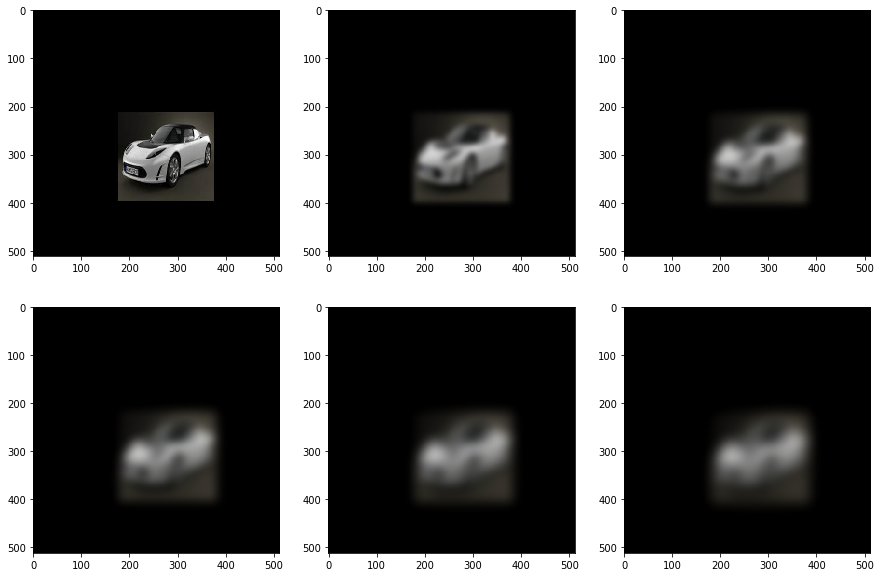

In [11]:
fgbg = gauss_pyramid(b1)
fggg = gauss_pyramid(g1)
fgrg = gauss_pyramid(r1)

res = np.zeros((fgbg[0].shape[0],fgbg[0].shape[1],3))

images =[]
for i in range(len(fgbg)):
    res = np.zeros((fgbg[0].shape[0],fgbg[0].shape[1],3))
    res[:,:,2] = fgbg[i]
    res[:,:,1] = fggg[i]
    res[:,:,0] = fgrg[i]
    res = np.clip(res.astype(int),0,255)
    images.append(res)
    
fig, axs = plt.subplots(2, 3, figsize=(15,10))

def plot_row(ax, images, cols):
    bins = np.arange(0, 1, .001)
    for i in range(cols):
        ax[0][i].imshow(images[i])
        ax[1][i].imshow(images[i+3])
    
plot_row(axs, images, 3)   

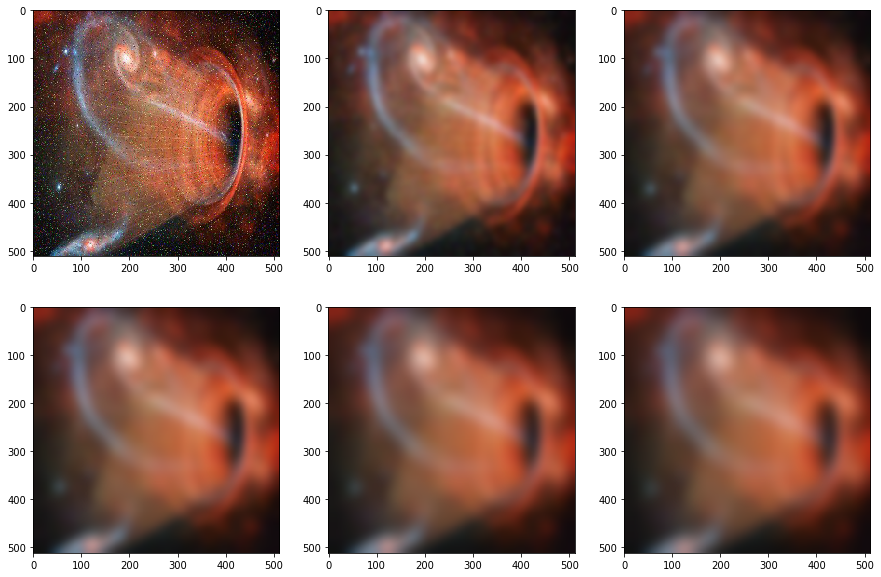

In [12]:
bgbg = gauss_pyramid(b2)
bggg = gauss_pyramid(g2)
bgrg = gauss_pyramid(r2)

res = np.zeros((fgbg[0].shape[0],fgbg[0].shape[1],3))

images =[]
for i in range(len(bgbg)):
    res = np.zeros((bgbg[0].shape[0],bgbg[0].shape[1],3))
    res[:,:,2] = bgbg[i]
    res[:,:,1] = bggg[i]
    res[:,:,0] = bgrg[i]
    res = np.clip(res.astype(int),0,255)
    images.append(res)
    
fig, axs = plt.subplots(2, 3, figsize=(15,10))

def plot_row(ax, images, cols):
    bins = np.arange(0, 1, .001)
    for i in range(cols):
        ax[0][i].imshow(images[i])
        ax[1][i].imshow(images[i+3])
    
plot_row(axs, images, 3)     